In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from google.colab import drive
import networkx as nx
import copy



device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
    else:
        print(gpu_info)
print('device :',device)
print('torch.version :',torch.__version__)

device : cpu
torch.version : 1.7.0+cu101


In [23]:
drive.mount('/content/drive')
folder_dir = '/content/drive/My Drive/cora'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
class Cora(object):
    
    def __init__(self, base_dir):
        data = np.genfromtxt(base_dir + '/cora/cora.content', dtype=np.str)
        

        self.category_list = list(set(data[:, -1]))
        self.cat2lab = {category:label for label, category in enumerate(self.category_list)}
        self.lab2cat = {label:category for label, category in enumerate(self.category_list)}
        
        self.paper_list = np.array(data[:, 0], dtype=np.int)
        self.paper2node = {paper_id:node_id for node_id, paper_id in enumerate(self.paper_list)}
        self.node2paper = {node_id:paper_id for node_id, paper_id in enumerate(self.paper_list)}


        self.node_feature = np.array(data[:, 1:-1], dtype=int)
        self.node_label = [self.cat2lab[category] for category in data[:, -1]]
        
        self.edge = np.genfromtxt(base_dir + '/cora/cora.cites',   dtype=np.int)
        self.node_connection = [[] for _ in range(data.shape[0])]


        for i, (cited, citing) in enumerate(self.edge):
            cited_node = self.paper2node[cited]
            citing_node = self.paper2node[citing]
            self.node_connection[cited_node].append(citing_node)
            self.node_connection[citing_node].append(cited_node) # undirected
            
        for i in range(data.shape[0]):
            self.node_connection[i] = np.array(list(set(self.node_connection[i])), dtype=np.int)




    def get_dataset(self):

        node_x = np.array(self.node_feature, dtype=np.int32)
        node_y = np.array(self.node_label, dtype=np.int32)
        node_neighbor_list = copy.deepcopy(self.node_connection)
        return node_x, node_y, node_neighbor_list
        

cora = Cora(base_dir='/content/drive/My Drive')




node_x, node_y, node_neighbor_list = cora.get_dataset()
node_x = torch.Tensor(node_x)



In [52]:



class DeepWalk(nn.Module):
    def __init__(self, num_nodes, feature_dim, hidden_dim, embedding_dim, dropout_p=0.5):
        super().__init__()

        self.num_nodes = num_nodes
        self.feature_dim = feature_dim
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim

        self.embedding1 = nn.Embedding(num_nodes, hidden_dim)

        self.feature_out = nn.Linear(hidden_dim, feature_dim, False)

        self.embedding2 = nn.Linear(hidden_dim, embedding_dim, False)

        self.node_out = nn.Linear(embedding_dim, num_nodes, False)


        self.drop_f = nn.Dropout(dropout_p)
        self.drop_e = nn.Dropout(dropout_p)



    def forward(self, index):



        hidden = self.embedding1(index)
        feature_out = self.feature_out(self.drop_f(hidden))
        feature_out = torch.sigmoid(feature_out)
        embedding = self.embedding2(self.drop_e(hidden))
        node_out = self.node_out(embedding)

        return node_out, feature_out

In [53]:

def deep_walk(model, node_x, node_neighbor_list, walk_length, window_size, num_epochs, learning_rate):


    solver = optim.Adam(model.parameters(), learning_rate)


    num_nodes, num_feature = node_x.size()

    
    start_list = np.arange(0, num_nodes)



    for epoch in range(num_epochs):

        np.random.shuffle(start_list)

        epoch_loss = 0.0
        for i in range(num_nodes):


            # generate a walk(=sentence)
            walk = [start_list[i]]
            for t in range(walk_length):
                curr_node_neigbhors = node_neighbor_list[walk[-1]]
                selected_next_node = np.random.choice(curr_node_neigbhors, 1)[0]
                walk.append(selected_next_node)


            # walk -> data pair
            data_index = []
            data_neigb = []

            for j in range(walk_length):
                for k in range(j - window_size, j + window_size + 1):
                    if k >= 0 and k < walk_length:
                        data_index.append(walk[j])
                        data_neigb.append(walk[k])


            data_index = torch.LongTensor(data_index)

            data_feature = node_x[data_index, :]
            data_neigb = torch.LongTensor(data_neigb)


            

            # one mini-batch leanring. mini-batch is data from a walk
            solver.zero_grad()
            node_out, feature_out = model(data_index)
        
            node_loss = F.cross_entropy(node_out, data_neigb) * num_nodes
            feature_loss = F.binary_cross_entropy(feature_out, data_feature) * num_feature
            (node_loss + 0.1 * feature_loss).backward()
            epoch_loss += node_loss.item()
            solver.step()
                        

        if epoch % 10 == 9:

            print(epoch_loss / num_nodes)



model = DeepWalk(num_nodes=node_x.size(0), feature_dim=node_x.size(1), hidden_dim=16, embedding_dim=2, dropout_p=0.5)

deep_walk(model, node_x, node_neighbor_list, 20, 8, 100, 0.001)

19011.55200015002
18414.527733221013
18303.78842203656
18264.337910459173
18228.05890568743
18218.00785938077
18244.927151250347
18276.90518328217
18220.924085608614
18216.943881915275


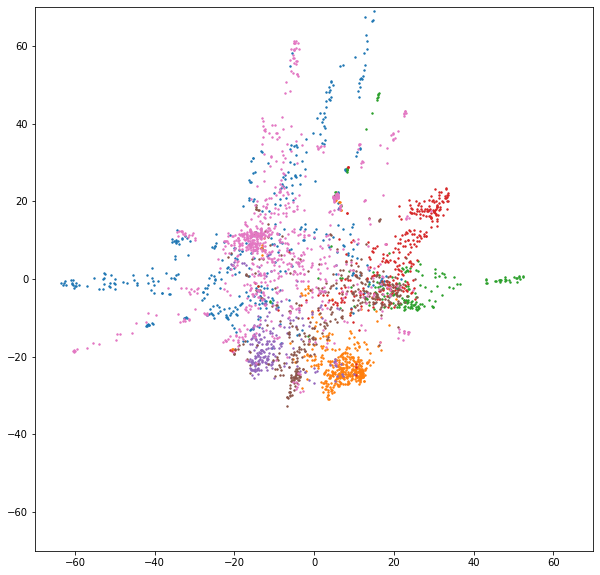

In [57]:
labels = np.array(cora.node_label)
# print(labels)

embs = (model.embedding1.weight @ model.embedding2.weight.transpose(0, 1)).detach().numpy()

plt.figure(figsize=(10, 10))


for i in range(7):
    node_list = labels == i
    plt.scatter(embs[node_list, 0], embs[node_list, 1], s=2)
plt.xlim(-70, 70)
plt.ylim(-70, 70)

plt.show()
